In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from astropy.timeseries import TimeSeries
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath("../src"))
import fileIO_processing as fp
import lightcurve_processing as lp


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

project_root = os.path.abspath(os.path.join(os.path.dirname('mid-ir-agn-dust-reverberation'), ".."))
IMPORT_FILEPATH = os.path.join(project_root, "data")


mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data


# Using the FixedWidthModel

The $\texttt{FixedWidthModel}$ class is designed to handle a single Plate-IFU. You can optionally provide it with a precomputed combined optical light curve Gaussian Process (GP) to save computation time. If you do not supply one, the class will generate the GP internally when instantiated.

The method $\texttt{FixedWidthModel.minimize\_chisq()}$ performs a complete chi-square minimization procedure.

This method accepts an argument $\texttt{IR\_data}$, which can be either the integer 1, 2, or an Astropy $\texttt{TimeSeries}$ object. If $\texttt{IR\_data}$ is 1 or 2, it automatically uses the corresponding W1 or W2 infrared data. Alternatively, you can pass your own IR $\texttt{TimeSeries}$ for fitting. Make sure that your custom $\texttt{TimeSeries}$ contains the columns $\texttt{"time"}$, $\texttt{"mag"}$, and $\texttt{"mag\_err"}$.

One feature not yet implemented in this class—but potentially useful—is a weighting function for the chi-square fit that penalizes longer lags. This function would increase the chi-square value for longer lags by applying higher weights, discouraging unrealistic lag solutions.


In [2]:
#select your Plate-IFU.
pifu = '10223-3701'#'8553-1901'#'8619-12702'
print(pifu)

10223-3701


## Using the Optical GP

In [3]:
from reverberation_mapper import FixedWidthModel

#Load in the optical GP
opt_GP = TimeSeries.read(os.path.join(IMPORT_FILEPATH, 'GP', pifu+'.txt'), format='ascii.ipac', time_column='time', time_format='decimalyear')

#Instantiate the FixedWidthModel object, and feed it the optical GP. If verbose=1 or True, it will print out status statements.
fwm = FixedWidthModel(pifu, optical_GP=opt_GP, verbose=0, optical_data_mode='gp')

#These are keyword arguments for the minimizer. Right now, we have specified a range of lags from -5 to 5 years in steps of 0.01 years.
minimizer_args = dict(ranges=((-5, 5, 0.01),), weighted=1)

#Minimize the chi-square for W1 data (IR_data is set to 1)
model1 = fwm.minimize_chisq(IR_data=1, **minimizer_args)
w1_results = np.array(fwm.results_log.copy())  #w1_results contains the best fit parameters: (lag, amp, const, chisq)

#Minimize the chi-square for W2 data (IR_data is set to 2)
model2 = fwm.minimize_chisq(IR_data=2, **minimizer_args) 
w2_results = np.array(fwm.results_log.copy()) #w2_results contains the best fit parameters: (lag, amp, const, chisq)

In [4]:
# Convolve the first model light curve (model1[0]) with a top-hat kernel of width 0.5 * lag
# Returns the convolved flux, corresponding time array, and propagated error
convw1, t_convw1, err_convw1 = fwm.convolve(model1[0], 0.5)

# Predict magnitudes for the W1 band using the convolved model and the W1 data
# Returns predicted magnitudes, errors, time array, and best-fit amplitude and offset
predw1, err_predw1, t_predw1, a1, c1, _ = fwm.predict_mags([model1[0]], fwm.w1)

# Convolve the second model light curve (model2[0]) with a top-hat kernel of width 0.5 * lag
convw2, t_convw2, err_convw2 = fwm.convolve(model2[0], 0.5)

# Predict magnitudes for the W2 band using the convolved model and the W2 data
predw2, err_predw2, t_predw2, a2, c2, _ = fwm.predict_mags([model2[0]], fwm.w2)


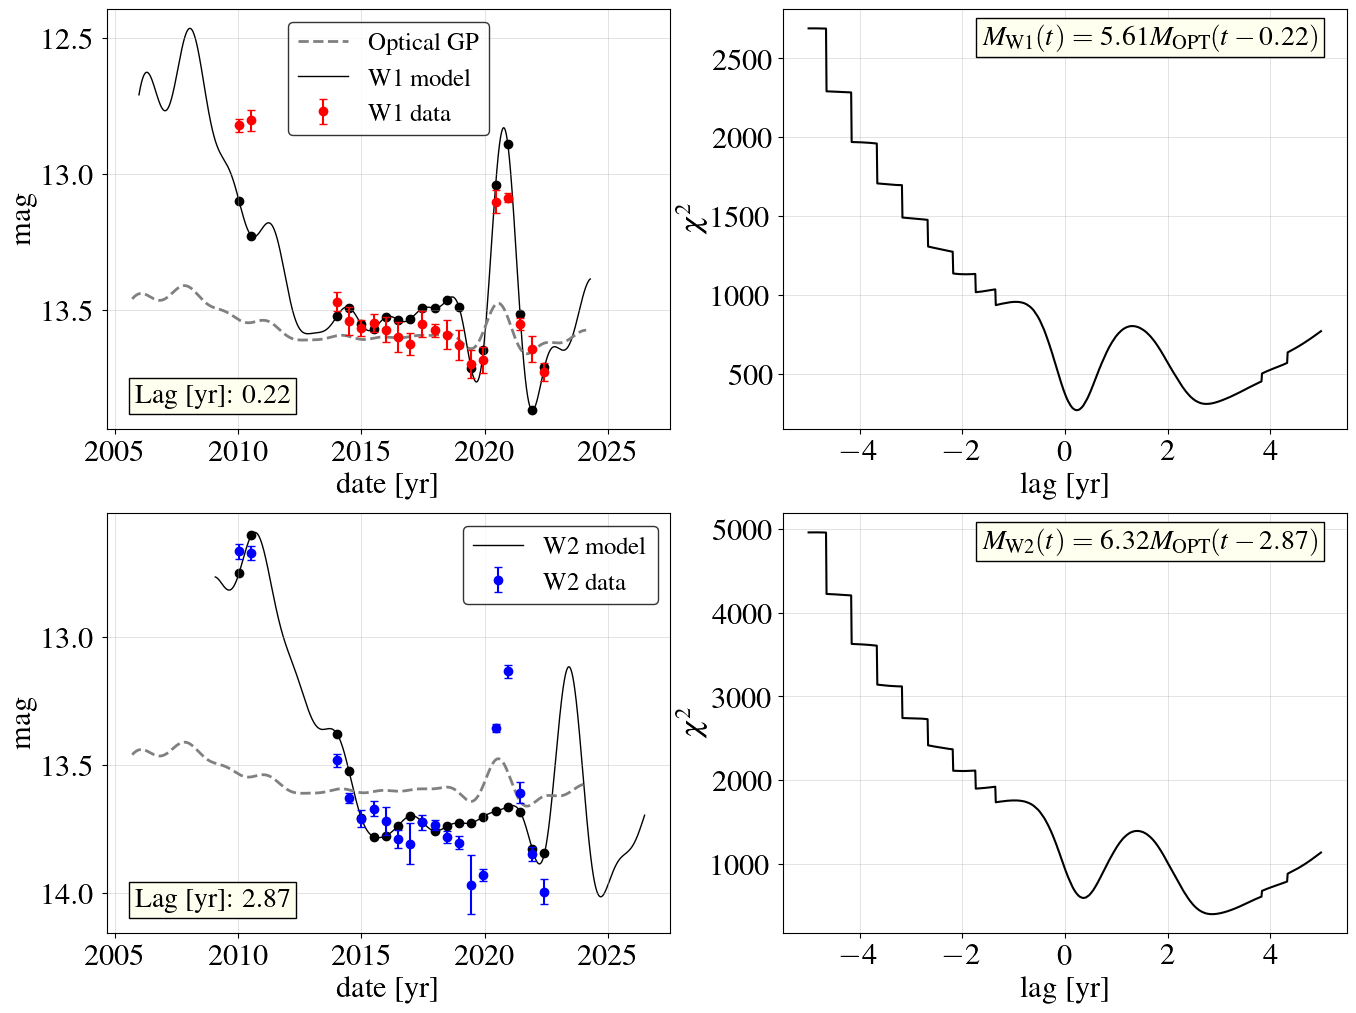

In [5]:
# Create a 2x2 grid of subplots with a large figure size (16x12 inches)
fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)

# Top-left plot: Optical GP light curve and W1 model comparison
ax[0, 0].plot(
    fwm.t_opt,  # Convert time to decimal years for x-axis
    fwm.m_opt,                          # Magnitudes from optical Gaussian Process
    c='grey', lw=2, ls='dashed', label='Optical GP'  # Grey dashed line for optical GP data
)

# Plot W1 model light curve: convolved and scaled model shifted by lag
ax[0, 0].plot(
    t_convw1 + model1[0],                           # Shift time by lag (model1[0])
    model1[1] * convw1 + model1[2],                 # Scale and offset convolved model flux
    c='k', lw=1, label='W1 model', zorder=-1       # Black line, behind other plots
)

# Scatter predicted W1 magnitudes on the same plot
ax[0, 0].scatter(t_predw1, predw1, c='k')

# Plot actual W1 data points with error bars (red circles)
ax[0, 0].errorbar(
    fwm.w1['time'].to_value('decimalyear'),         # W1 observation times in decimal years
    fwm.w1['mag'],                                  # W1 magnitudes
    yerr=fwm.w1['mag_err'],                         # Errors on magnitudes
    c='red', capsize=3, linestyle='none', marker='o', label='W1 data'
)

# Add a text box showing the lag value in years on the bottom left
ax[0, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model1[0], 3)),  # Lag rounded to 3 decimals
    ha='left', va='bottom', fontsize=20,
    transform=ax[0, 0].transAxes,                          # Coordinates relative to axes
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), # Ivory background with black border
    zorder=5                                              # Draw on top
)

# Invert y-axis so that magnitude decreases upward
ax[0, 0].invert_yaxis()

# Add legend with black edge and larger font
ax[0, 0].legend(edgecolor='k', fontsize=18)

# Label axes
ax[0, 0].set_ylabel('mag')
ax[0, 0].set_xlabel('date [yr]')

# Top-right plot: Chi-squared vs lag for W1 results
ax[0, 1].set_xlabel('lag [yr]')
ax[0, 1].set_ylabel(r'$\chi^2$')

# Plot chi-squared values from W1 fitting results
ax[0, 1].plot(w1_results[:, 0], w1_results[:, 3], c='k')

# Add text showing the W1 model equation and fitted parameters on top right
ax[0, 1].text(
    0.95, 0.9,
    r'$M_{\rm W1}(t)=' + str(np.round(model1[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model1[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[0, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Bottom-left plot: Optical GP and W2 model comparison (similar to top-left)
ax[1, 0].plot(
    fwm.t_opt,
    fwm.m_opt,
    c='grey', lw=2, ls='dashed'
)
ax[1, 0].plot(
    t_convw2 + model2[0],
    model2[1] * convw2 + model2[2],
    c='k', lw=1, label='W2 model', zorder=-1
)
ax[1, 0].scatter(t_predw2, predw2, c='k')
ax[1, 0].errorbar(
    fwm.w2['time'].to_value('decimalyear'),
    fwm.w2['mag'],
    yerr=fwm.w2['mag_err'],
    c='blue', capsize=3, linestyle='none', marker='o', label='W2 data'
)

# Add lag text box on bottom left
ax[1, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model2[0], 3)),
    ha='left', va='bottom', fontsize=20,
    transform=ax[1, 0].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Invert y-axis for magnitudes
ax[1, 0].invert_yaxis()

# Legend and axis labels
ax[1, 0].legend(edgecolor='k', fontsize=18)
ax[1, 0].set_ylabel('mag')
ax[1, 0].set_xlabel('date [yr]')

# Bottom-right plot: Chi-squared vs lag for W2 results
ax[1, 1].set_ylabel(r'$\chi^2$')
ax[1, 1].set_xlabel('lag [yr]')
ax[1, 1].plot(w2_results[:, 0], w2_results[:, 3], c='k')

# Add W2 model equation text box
ax[1, 1].text(
    0.95, 0.9,
    r'$M_{\rm W2}(t)=' + str(np.round(model2[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model2[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[1, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Add grid lines with light opacity and thin lines to all four subplots
for i in range(2):
    for j in range(2):
        ax[i, j].grid(lw=0.5, alpha=0.5)

# Make the x-axis of the top-left and bottom-left plots share the same scale
ax[0, 0].sharex(ax[1, 0])


## Using the combined optical lightcurve

In [6]:
from reverberation_mapper import FixedWidthModel

#Load in the optical GP
opt_lc, _ = lp.generate_combined_lightcurve(pifu)
#Instantiate the FixedWidthModel object, and feed it the optical GP. If verbose=1 or True, it will print out status statements.
fwm = FixedWidthModel(pifu, optical_data=opt_lc, verbose=0, optical_data_mode='raw')

#These are keyword arguments for the minimizer. Right now, we have specified a range of lags from -5 to 5 years in steps of 0.01 years.
minimizer_args = dict(ranges=((-5, 5, 0.01),), weighted=1)

#Minimize the chi-square for W1 data (IR_data is set to 1)
model1 = fwm.minimize_chisq(IR_data=1, **minimizer_args)
w1_results = np.array(fwm.results_log.copy())  #w1_results contains the best fit parameters: (lag, amp, const, chisq)

#Minimize the chi-square for W2 data (IR_data is set to 2)
model2 = fwm.minimize_chisq(IR_data=2, **minimizer_args) 
w2_results = np.array(fwm.results_log.copy()) #w2_results contains the best fit parameters: (lag, amp, const, chisq)

using padded times


In [7]:
# Convolve the first model light curve (model1[0]) with a top-hat kernel of width 0.5 * lag
# Returns the convolved flux, corresponding time array, and propagated error
convw1, t_convw1, err_convw1 = fwm.convolve(model1[0], 0.5)

# Predict magnitudes for the W1 band using the convolved model and the W1 data
# Returns predicted magnitudes, errors, time array, and best-fit amplitude and offset
predw1, err_predw1, t_predw1, a1, c1, _ = fwm.predict_mags([model1[0]], fwm.w1)

# Convolve the second model light curve (model2[0]) with a top-hat kernel of width 0.5 * lag
convw2, t_convw2, err_convw2 = fwm.convolve(model2[0], 0.5)

# Predict magnitudes for the W2 band using the convolved model and the W2 data
predw2, err_predw2, t_predw2, a2, c2, _ = fwm.predict_mags([model2[0]], fwm.w2)


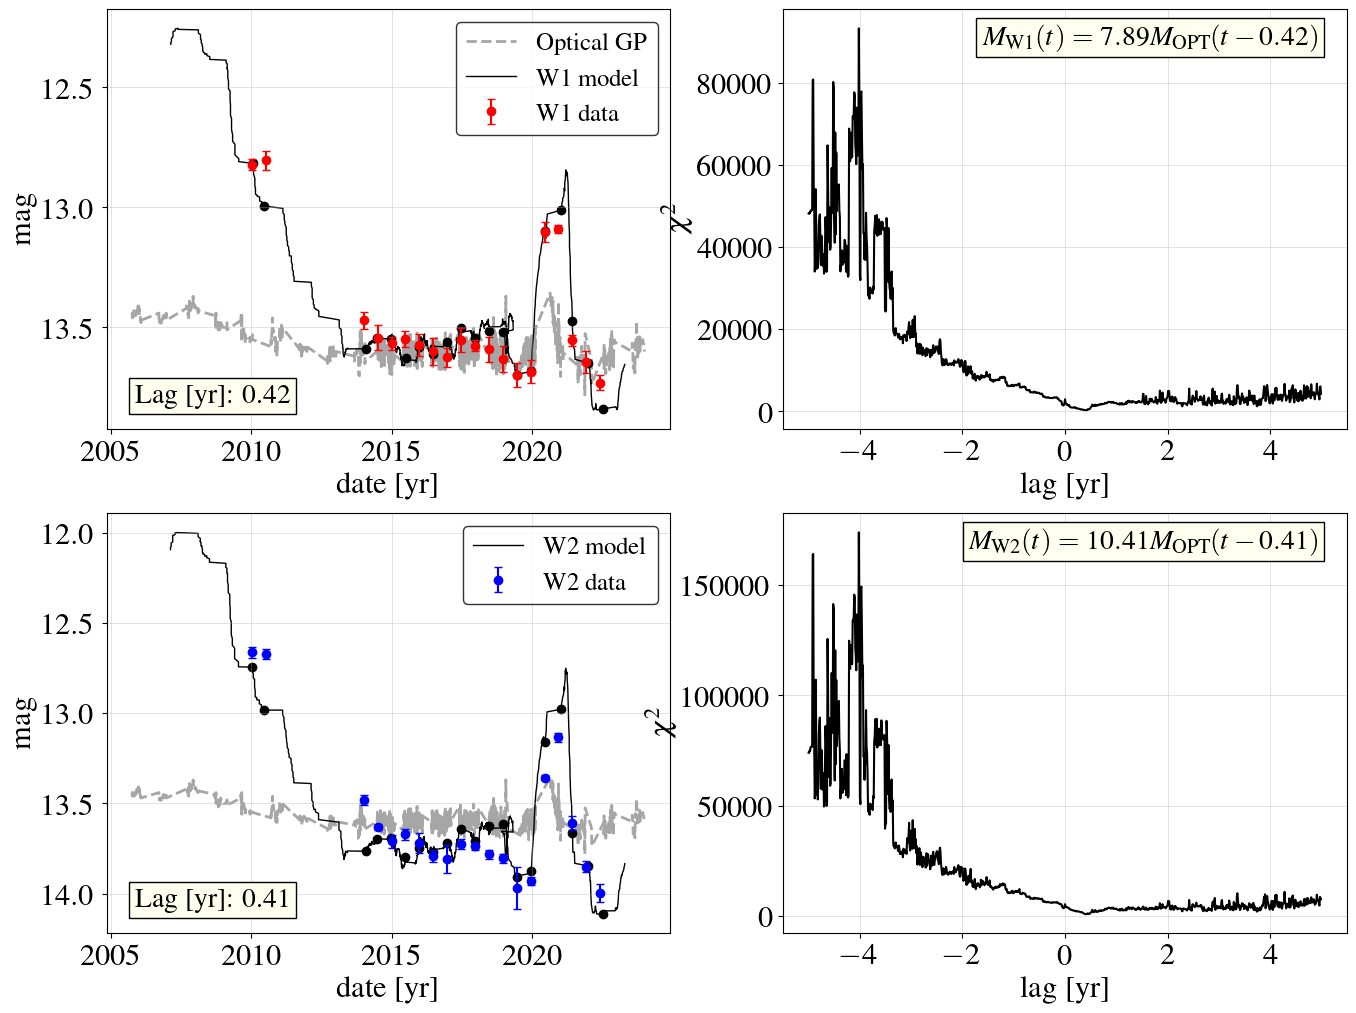

In [8]:
# Create a 2x2 grid of subplots with a large figure size (16x12 inches)
fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)

# Top-left plot: Optical GP light curve and W1 model comparison
ax[0, 0].plot(
    fwm.t_opt,  # Convert time to decimal years for x-axis
    fwm.m_opt,                          # Magnitudes from optical Gaussian Process
    c='grey', lw=2, ls='dashed', label='Optical GP',
      zorder=-1, alpha=0.7                            # Grey dashed line for optical GP data
)

# Plot W1 model light curve: convolved and scaled model shifted by lag
ax[0, 0].plot(
    t_convw1 + model1[0],                           # Shift time by lag (model1[0])
    model1[1] * convw1 + model1[2],                 # Scale and offset convolved model flux
    c='k', lw=1, label='W1 model', zorder=-1       # Black line, behind other plots
)

# Scatter predicted W1 magnitudes on the same plot
ax[0, 0].scatter(t_predw1, predw1, c='k')

# Plot actual W1 data points with error bars (red circles)
ax[0, 0].errorbar(
    fwm.w1['time'].to_value('decimalyear'),         # W1 observation times in decimal years
    fwm.w1['mag'],                                  # W1 magnitudes
    yerr=fwm.w1['mag_err'],                         # Errors on magnitudes
    c='red', capsize=3, linestyle='none', marker='o', label='W1 data'
)

# Add a text box showing the lag value in years on the bottom left
ax[0, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model1[0], 3)),  # Lag rounded to 3 decimals
    ha='left', va='bottom', fontsize=20,
    transform=ax[0, 0].transAxes,                          # Coordinates relative to axes
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), # Ivory background with black border
    zorder=5                                              # Draw on top
)

# Invert y-axis so that magnitude decreases upward
ax[0, 0].invert_yaxis()

# Add legend with black edge and larger font
ax[0, 0].legend(edgecolor='k', fontsize=18)

# Label axes
ax[0, 0].set_ylabel('mag')
ax[0, 0].set_xlabel('date [yr]')

# Top-right plot: Chi-squared vs lag for W1 results
ax[0, 1].set_xlabel('lag [yr]')
ax[0, 1].set_ylabel(r'$\chi^2$')

# Plot chi-squared values from W1 fitting results
ax[0, 1].plot(w1_results[:, 0], w1_results[:, 3], c='k')

# Add text showing the W1 model equation and fitted parameters on top right
ax[0, 1].text(
    0.95, 0.9,
    r'$M_{\rm W1}(t)=' + str(np.round(model1[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model1[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[0, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Bottom-left plot: Optical GP and W2 model comparison (similar to top-left)
ax[1, 0].plot(
    fwm.t_opt,
    fwm.m_opt,
    c='grey', lw=2, ls='dashed', zorder=-1, alpha=0.7
)
ax[1, 0].plot(
    t_convw2 + model2[0],
    model2[1] * convw2 + model2[2],
    c='k', lw=1, label='W2 model', zorder=-1
)
ax[1, 0].scatter(t_predw2, predw2, c='k')
ax[1, 0].errorbar(
    fwm.w2['time'].to_value('decimalyear'),
    fwm.w2['mag'],
    yerr=fwm.w2['mag_err'],
    c='blue', capsize=3, linestyle='none', marker='o', label='W2 data'
)

# Add lag text box on bottom left
ax[1, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model2[0], 3)),
    ha='left', va='bottom', fontsize=20,
    transform=ax[1, 0].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Invert y-axis for magnitudes
ax[1, 0].invert_yaxis()

# Legend and axis labels
ax[1, 0].legend(edgecolor='k', fontsize=18)
ax[1, 0].set_ylabel('mag')
ax[1, 0].set_xlabel('date [yr]')

# Bottom-right plot: Chi-squared vs lag for W2 results
ax[1, 1].set_ylabel(r'$\chi^2$')
ax[1, 1].set_xlabel('lag [yr]')
ax[1, 1].plot(w2_results[:, 0], w2_results[:, 3], c='k')

# Add W2 model equation text box
ax[1, 1].text(
    0.95, 0.9,
    r'$M_{\rm W2}(t)=' + str(np.round(model2[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model2[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[1, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Add grid lines with light opacity and thin lines to all four subplots
for i in range(2):
    for j in range(2):
        ax[i, j].grid(lw=0.5, alpha=0.5)

# Make the x-axis of the top-left and bottom-left plots share the same scale
ax[0, 0].sharex(ax[1, 0])
